In [ ]:
# 🕵️ Deepfake Detection - Comprehensive Exploratory Data Analysis

## 📊 Overview
This notebook provides a comprehensive analysis of the deepfake detection datasets including:
- **Celeb-DF-v2**: Celebrity deepfake dataset with real and synthetic videos
- **FaceForensics++**: Preprocessed face crops from manipulated videos
- **YouTube Real**: Authentic celebrity videos from YouTube

### 🎯 Objectives
1. **Dataset Discovery & Scanning** - Identify all available data files
2. **Statistical Analysis** - Compute descriptive statistics and distributions
3. **Video Properties Analysis** - Duration, FPS, resolution analysis
4. **Image Quality Assessment** - Blur detection, noise analysis, resolution
5. **Visual Exploration** - Sample displays and comparative analysis
6. **Data Quality Report** - Comprehensive summary for model training

---

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Computer Vision Libraries
import cv2
from PIL import Image, ImageStat
import os
from pathlib import Path
import json

# Statistical Analysis
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotly configuration
import plotly.io as pio
pio.templates.default = "plotly_white"

print("📦 All libraries imported successfully!")
print("🎨 Styling configured for beautiful visualizations")

📦 All libraries imported successfully!
🎨 Styling configured for beautiful visualizations


## 🗂️ Data Discovery & Dataset Scanning

In [2]:
# Dataset Configuration
base_path = Path("/home/soumya/PycharmProjects/Deepfake_Detection")
celeb_df_path = base_path / "Celeb-df-v2"
faceforensics_path = base_path / "FaceForensics"

print(f"🔍 Base Path: {base_path}")
print(f"📁 Celeb-DF Path: {celeb_df_path}")
print(f"📁 FaceForensics Path: {faceforensics_path}")

# Verify paths exist
print(f"\n✅ Path Verification:")
print(f"Base path exists: {base_path.exists()}")
print(f"Celeb-DF exists: {celeb_df_path.exists()}")
print(f"FaceForensics exists: {faceforensics_path.exists()}")

# Dataset structure exploration
def explore_directory_structure(path, max_depth=3, current_depth=0):
    """Recursively explore directory structure"""
    items = []
    if path.exists() and current_depth < max_depth:
        try:
            for item in sorted(path.iterdir()):
                if item.is_dir():
                    sub_items = len(list(item.iterdir())) if item.exists() else 0
                    items.append({
                        'path': str(item.relative_to(base_path)),
                        'type': 'directory',
                        'items': sub_items,
                        'depth': current_depth
                    })
                    # Recursively explore subdirectories
                    items.extend(explore_directory_structure(item, max_depth, current_depth + 1))
                else:
                    items.append({
                        'path': str(item.relative_to(base_path)),
                        'type': 'file',
                        'size': item.stat().st_size if item.exists() else 0,
                        'depth': current_depth
                    })
        except PermissionError:
            pass
    return items

print(f"\n🗂️ Exploring directory structure...")
structure_data = explore_directory_structure(base_path, max_depth=2)
structure_df = pd.DataFrame(structure_data)

if not structure_df.empty:
    print(f"📊 Found {len(structure_df)} items")
    print(f"📁 Directories: {len(structure_df[structure_df['type'] == 'directory'])}")
    print(f"📄 Files: {len(structure_df[structure_df['type'] == 'file'])}")
else:
    print("⚠️ No structure data found")

🔍 Base Path: /home/soumya/PycharmProjects/Deepfake_Detection
📁 Celeb-DF Path: /home/soumya/PycharmProjects/Deepfake_Detection/Celeb-df-v2
📁 FaceForensics Path: /home/soumya/PycharmProjects/Deepfake_Detection/FaceForensics

✅ Path Verification:
Base path exists: True
Celeb-DF exists: True
FaceForensics exists: True

🗂️ Exploring directory structure...
📊 Found 65 items
📁 Directories: 22
📄 Files: 43


In [11]:
# Comprehensive Dataset Scanning
def scan_deepfake_datasets():
    """Comprehensive scanning of all deepfake datasets"""
    
    datasets = {
        'celeb_real': [],
        'celeb_fake': [],
        'youtube_real': [],
        'faceforensics': []
    }
    
    print("🔍 Scanning Celeb-DF-v2 Dataset...")
    
    # Scan Celeb-DF Real Videos
    celeb_real_path = celeb_df_path / "Celeb-real"
    if celeb_real_path.exists():
        for video_file in celeb_real_path.glob("*.mp4"):
            datasets['celeb_real'].append({
                'filename': video_file.name,
                'path': str(video_file),
                'size_mb': video_file.stat().st_size / (1024 * 1024),
                'dataset': 'celeb-df',
                'type': 'real',
                'category': 'video',
                'file_type': 'mp4'
            })
    
    # Scan Celeb-DF Fake Videos
    celeb_fake_path = celeb_df_path / "Celeb-synthesis"
    if celeb_fake_path.exists():
        for video_file in celeb_fake_path.glob("*.mp4"):
            # Extract IDs from filename (format: sourceID_targetID.mp4)
            parts = video_file.stem.split('_')
            source_id = parts[0] if len(parts) > 0 else "unknown"
            target_id = parts[1] if len(parts) > 1 else "unknown"
            
            datasets['celeb_fake'].append({
                'filename': video_file.name,
                'path': str(video_file),
                'size_mb': video_file.stat().st_size / (1024 * 1024),
                'dataset': 'celeb-df',
                'type': 'fake',
                'category': 'video',
                'file_type': 'mp4',
                'source_id': source_id,
                'target_id': target_id
            })
    
    # Scan YouTube Real Videos
    youtube_path = celeb_df_path / "YouTube-real"
    if youtube_path.exists():
        for video_file in youtube_path.glob("*.mp4"):
            datasets['youtube_real'].append({
                'filename': video_file.name,
                'path': str(video_file),
                'size_mb': video_file.stat().st_size / (1024 * 1024),
                'dataset': 'youtube',
                'type': 'real',
                'category': 'video',
                'file_type': 'mp4'
            })
    
    # Scan FaceForensics Images
    ff_images_path = faceforensics_path / "cropped_images"
    if ff_images_path.exists():
        image_count = 0
        for folder in ff_images_path.iterdir():
            if folder.is_dir():
                for img_file in folder.glob("*.png"):
                    if image_count < 1000:  # Limit for performance
                        datasets['faceforensics'].append({
                            'filename': img_file.name,
                            'path': str(img_file),
                            'size_mb': img_file.stat().st_size / (1024 * 1024),
                            'dataset': 'faceforensics',
                            'type': 'unknown',  # Will be determined later
                            'category': 'image',
                            'file_type': 'png',
                            'folder': folder.name
                        })
                        image_count += 1
    
    return datasets

# Perform the scan
print("🚀 Starting comprehensive dataset scan...")
dataset_scan = scan_deepfake_datasets()

# Create summary statistics
scan_summary = {}
total_files = 0
total_size_gb = 0

for dataset_name, files in dataset_scan.items():
    count = len(files)
    size_gb = sum(f['size_mb'] for f in files) / 1024
    scan_summary[dataset_name] = {
        'count': count,
        'size_gb': size_gb
    }
    total_files += count
    total_size_gb += size_gb
    print(f"📊 {dataset_name}: {count} files ({size_gb:.2f} GB)")

print(f"\n📈 Total Summary:")
print(f"   📁 Total Files: {total_files}")
print(f"   💾 Total Size: {total_size_gb:.2f} GB")

# Convert to DataFrame for analysis
all_files = []
for dataset_name, files in dataset_scan.items():
    for file_info in files:
        file_info['dataset_category'] = dataset_name
        all_files.append(file_info)

df_files = pd.DataFrame(all_files)
print(f"\n✅ Created master dataset with {len(df_files)} files")

🚀 Starting comprehensive dataset scan...
🔍 Scanning Celeb-DF-v2 Dataset...
📊 celeb_real: 590 files (0.88 GB)
📊 celeb_fake: 5639 files (7.93 GB)
📊 youtube_real: 300 files (0.65 GB)
📊 faceforensics: 1000 files (0.03 GB)

📈 Total Summary:
   📁 Total Files: 7529
   💾 Total Size: 9.49 GB

✅ Created master dataset with 7529 files


In [4]:
# Dataset Overview Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Dataset Distribution', 'File Size Distribution', 
                   'File Type Analysis', 'Dataset Size Comparison'),
    specs=[[{"type": "pie"}, {"type": "histogram"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# 1. Dataset Distribution (Pie Chart)
dataset_counts = df_files['dataset_category'].value_counts()
fig.add_trace(
    go.Pie(labels=dataset_counts.index, values=dataset_counts.values,
           name="Dataset Distribution"),
    row=1, col=1
)

# 2. File Size Distribution (Histogram)
fig.add_trace(
    go.Histogram(x=df_files['size_mb'], nbinsx=50, name="Size Distribution"),
    row=1, col=2
)

# 3. File Type Analysis (Bar Chart)
type_counts = df_files['category'].value_counts()
fig.add_trace(
    go.Bar(x=type_counts.index, y=type_counts.values, name="File Types"),
    row=2, col=1
)

# 4. Dataset Size Comparison (Bar Chart)
size_by_dataset = df_files.groupby('dataset_category')['size_mb'].sum() / 1024  # Convert to GB
fig.add_trace(
    go.Bar(x=size_by_dataset.index, y=size_by_dataset.values, name="Dataset Sizes (GB)"),
    row=2, col=2
)

fig.update_layout(
    height=800,
    title_text="📊 Deepfake Dataset Overview Dashboard",
    showlegend=False
)

fig.show()

# Print detailed statistics
print("📈 DETAILED DATASET STATISTICS")
print("=" * 50)
print(f"Total datasets: {df_files['dataset'].nunique()}")
print(f"Total files: {len(df_files)}")
print(f"Total size: {df_files['size_mb'].sum()/1024:.2f} GB")
print(f"Average file size: {df_files['size_mb'].mean():.2f} MB")
print(f"Median file size: {df_files['size_mb'].median():.2f} MB")
print(f"Largest file: {df_files['size_mb'].max():.2f} MB")
print(f"Smallest file: {df_files['size_mb'].min():.4f} MB")

📈 DETAILED DATASET STATISTICS
Total datasets: 3
Total files: 7529
Total size: 9.49 GB
Average file size: 1.29 MB
Median file size: 1.27 MB
Largest file: 6.32 MB
Smallest file: 0.0165 MB


## 🎬 Video Properties Analysis

In [5]:
# Video Properties Analysis
def analyze_video_properties(video_path, max_videos=50):
    """Analyze video properties like duration, FPS, resolution"""
    video_properties = []
    
    try:
        cap = cv2.VideoCapture(str(video_path))
        if cap.isOpened():
            # Get video properties
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            duration = frame_count / fps if fps > 0 else 0
            
            cap.release()
            
            return {
                'fps': fps,
                'duration': duration,
                'frame_count': frame_count,
                'width': width,
                'height': height,
                'resolution': f"{width}x{height}",
                'aspect_ratio': width / height if height > 0 else 0
            }
    except Exception as e:
        print(f"Error analyzing {video_path}: {e}")
    
    return None

# Analyze video properties for each dataset
print("🎬 Analyzing video properties...")
video_analysis = []

# Analyze videos from each category
video_categories = ['celeb_real', 'celeb_fake', 'youtube_real']
for category in video_categories:
    videos = [f for f in all_files if f['dataset_category'] == category and f['category'] == 'video']
    print(f"📹 Analyzing {len(videos)} videos from {category}")
    
    for i, video_info in enumerate(videos[:20]):  # Analyze first 20 videos per category
        if i % 5 == 0:
            print(f"   Processing {i+1}/{min(20, len(videos))} videos...")
        
        props = analyze_video_properties(video_info['path'])
        if props:
            props.update({
                'filename': video_info['filename'],
                'dataset_category': category,
                'dataset': video_info['dataset'],
                'type': video_info['type'],
                'size_mb': video_info['size_mb']
            })
            video_analysis.append(props)

# Convert to DataFrame
df_videos = pd.DataFrame(video_analysis)

if not df_videos.empty:
    print(f"✅ Successfully analyzed {len(df_videos)} videos")
    
    # Display basic statistics
    print(f"\n📊 Video Statistics Summary:")
    print(f"Average duration: {df_videos['duration'].mean():.2f} seconds")
    print(f"Average FPS: {df_videos['fps'].mean():.2f}")
    print(f"Most common resolution: {df_videos['resolution'].mode().iloc[0] if not df_videos['resolution'].mode().empty else 'N/A'}")
    print(f"Average aspect ratio: {df_videos['aspect_ratio'].mean():.2f}")
else:
    print("⚠️ No video analysis data available")

🎬 Analyzing video properties...
📹 Analyzing 590 videos from celeb_real
   Processing 1/20 videos...
   Processing 6/20 videos...
   Processing 11/20 videos...
   Processing 16/20 videos...
📹 Analyzing 5639 videos from celeb_fake
   Processing 1/20 videos...
   Processing 6/20 videos...
   Processing 11/20 videos...
   Processing 16/20 videos...
📹 Analyzing 300 videos from youtube_real
   Processing 1/20 videos...
   Processing 6/20 videos...
   Processing 11/20 videos...
   Processing 16/20 videos...
✅ Successfully analyzed 60 videos

📊 Video Statistics Summary:
Average duration: 13.39 seconds
Average FPS: 30.00
Most common resolution: 892x500
Average aspect ratio: 1.74


In [6]:
# Video Properties Visualization
if not df_videos.empty:
    # Create comprehensive video analysis dashboard
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Duration Distribution', 'FPS Distribution',
                       'Resolution Analysis', 'Aspect Ratio Distribution',
                       'Duration vs File Size', 'Properties by Dataset'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "bar"}, {"secondary_y": False}],
               [{"secondary_y": False}, {"type": "bar"}]]
    )
    
    # 1. Duration Distribution
    fig.add_trace(
        go.Histogram(x=df_videos['duration'], nbinsx=20, name="Duration (seconds)",
                    marker_color='lightblue'),
        row=1, col=1
    )
    
    # 2. FPS Distribution
    fig.add_trace(
        go.Histogram(x=df_videos['fps'], nbinsx=15, name="FPS",
                    marker_color='lightgreen'),
        row=1, col=2
    )
    
    # 3. Resolution Analysis
    resolution_counts = df_videos['resolution'].value_counts().head(10)
    fig.add_trace(
        go.Bar(x=resolution_counts.values, y=resolution_counts.index, 
               orientation='h', name="Resolution Frequency",
               marker_color='orange'),
        row=2, col=1
    )
    
    # 4. Aspect Ratio Distribution
    fig.add_trace(
        go.Histogram(x=df_videos['aspect_ratio'], nbinsx=20, name="Aspect Ratio",
                    marker_color='purple'),
        row=2, col=2
    )
    
    # 5. Duration vs File Size Scatter
    fig.add_trace(
        go.Scatter(x=df_videos['duration'], y=df_videos['size_mb'],
                  mode='markers', name="Duration vs Size",
                  marker=dict(color=df_videos['fps'], colorscale='Viridis',
                             showscale=True, colorbar=dict(title="FPS"))),
        row=3, col=1
    )
    
    # 6. Properties by Dataset
    dataset_stats = df_videos.groupby('dataset_category').agg({
        'duration': 'mean',
        'fps': 'mean',
        'size_mb': 'mean'
    }).reset_index()
    
    fig.add_trace(
        go.Bar(x=dataset_stats['dataset_category'], y=dataset_stats['duration'],
               name="Avg Duration", marker_color='red'),
        row=3, col=2
    )
    
    fig.update_layout(
        height=1200,
        title_text="🎬 Comprehensive Video Properties Analysis",
        showlegend=False
    )
    
    fig.show()
    
    # Statistical analysis
    print("📈 DETAILED VIDEO STATISTICS")
    print("=" * 50)
    
    # Overall statistics
    print(f"Duration Statistics:")
    print(f"  Mean: {df_videos['duration'].mean():.2f}s")
    print(f"  Median: {df_videos['duration'].median():.2f}s")
    print(f"  Std: {df_videos['duration'].std():.2f}s")
    print(f"  Range: {df_videos['duration'].min():.2f}s - {df_videos['duration'].max():.2f}s")
    
    print(f"\nFPS Statistics:")
    print(f"  Mean: {df_videos['fps'].mean():.2f}")
    print(f"  Median: {df_videos['fps'].median():.2f}")
    print(f"  Most common: {df_videos['fps'].mode().iloc[0]:.1f}")
    
    print(f"\nResolution Analysis:")
    print(f"  Unique resolutions: {df_videos['resolution'].nunique()}")
    print(f"  Most common: {df_videos['resolution'].mode().iloc[0]}")
    print(f"  Resolution variety: {df_videos['resolution'].value_counts().head()}")
    
    # By dataset comparison
    print(f"\n📊 Comparison by Dataset:")
    comparison = df_videos.groupby(['dataset_category', 'type']).agg({
        'duration': ['mean', 'std', 'count'],
        'fps': ['mean', 'std'],
        'size_mb': ['mean', 'std']
    }).round(2)
    print(comparison)
    
else:
    print("⚠️ No video data available for visualization")

📈 DETAILED VIDEO STATISTICS
Duration Statistics:
  Mean: 13.39s
  Median: 14.20s
  Std: 2.66s
  Range: 6.97s - 17.57s

FPS Statistics:
  Mean: 30.00
  Median: 30.00
  Most common: 30.0

Resolution Analysis:
  Unique resolutions: 22
  Most common: 892x500
  Resolution variety: resolution
892x500    14
856x478     9
848x466     7
850x472     6
950x500     3
Name: count, dtype: int64

📊 Comparison by Dataset:
                      duration                  fps        size_mb       
                          mean    std count    mean    std    mean    std
dataset_category type                                                    
celeb_fake       fake  13.2700 2.7300    20 30.0000 0.0000  1.3800 0.5400
celeb_real       real  12.3200 2.7500    20 30.0000 0.0000  1.4900 0.7700
youtube_real     real  14.5800 2.0700    20 30.0000 0.0000  2.2800 0.8200


## 🖼️ Image Quality Assessment

In [7]:
# Image Quality Analysis Functions
def calculate_blur_score(image_path):
    """Calculate blur score using Laplacian variance"""
    try:
        image = cv2.imread(str(image_path))
        if image is not None:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return cv2.Laplacian(gray, cv2.CV_64F).var()
    except:
        pass
    return 0

def calculate_brightness_contrast(image_path):
    """Calculate brightness and contrast metrics"""
    try:
        image = cv2.imread(str(image_path))
        if image is not None:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            brightness = np.mean(gray)
            contrast = np.std(gray)
            return brightness, contrast
    except:
        pass
    return 0, 0

def calculate_noise_level(image_path):
    """Estimate noise level in image"""
    try:
        image = cv2.imread(str(image_path))
        if image is not None:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Use standard deviation of Laplacian as noise estimate
            noise = cv2.Laplacian(gray, cv2.CV_64F)
            return np.std(noise)
    except:
        pass
    return 0

def get_image_resolution_stats(image_path):
    """Get image resolution and basic stats"""
    try:
        image = cv2.imread(str(image_path))
        if image is not None:
            height, width = image.shape[:2]
            channels = image.shape[2] if len(image.shape) > 2 else 1
            total_pixels = height * width
            return {
                'width': width,
                'height': height, 
                'channels': channels,
                'total_pixels': total_pixels,
                'aspect_ratio': width / height if height > 0 else 0
            }
    except:
        pass
    return None

# Analyze image quality for FaceForensics dataset
print("🖼️ Analyzing image quality metrics...")
image_quality_analysis = []

# Get FaceForensics images
ff_images = [f for f in all_files if f['dataset_category'] == 'faceforensics']
print(f"📸 Found {len(ff_images)} FaceForensics images")

# Analyze a sample of images (limit for performance)
sample_size = min(100, len(ff_images))
print(f"🔬 Analyzing {sample_size} sample images...")

for i, img_info in enumerate(ff_images[:sample_size]):
    if i % 20 == 0:
        print(f"   Processing {i+1}/{sample_size} images...")
    
    img_path = img_info['path']
    
    # Calculate quality metrics
    blur_score = calculate_blur_score(img_path)
    brightness, contrast = calculate_brightness_contrast(img_path)
    noise_level = calculate_noise_level(img_path)
    resolution_stats = get_image_resolution_stats(img_path)
    
    if resolution_stats:
        quality_data = {
            'filename': img_info['filename'],
            'folder': img_info['folder'],
            'size_mb': img_info['size_mb'],
            'blur_score': blur_score,
            'brightness': brightness,
            'contrast': contrast,
            'noise_level': noise_level,
            **resolution_stats
        }
        image_quality_analysis.append(quality_data)

# Convert to DataFrame
df_image_quality = pd.DataFrame(image_quality_analysis)

if not df_image_quality.empty:
    print(f"✅ Successfully analyzed {len(df_image_quality)} images")
    
    # Display basic statistics
    print(f"\n📊 Image Quality Statistics:")
    print(f"Average blur score: {df_image_quality['blur_score'].mean():.2f}")
    print(f"Average brightness: {df_image_quality['brightness'].mean():.2f}")
    print(f"Average contrast: {df_image_quality['contrast'].mean():.2f}")
    print(f"Average noise level: {df_image_quality['noise_level'].mean():.2f}")
    print(f"Most common resolution: {df_image_quality['width'].mode().iloc[0]}x{df_image_quality['height'].mode().iloc[0]}")
else:
    print("⚠️ No image quality analysis data available")

🖼️ Analyzing image quality metrics...
📸 Found 1000 FaceForensics images
🔬 Analyzing 100 sample images...
   Processing 1/100 images...
   Processing 21/100 images...
   Processing 41/100 images...
   Processing 61/100 images...
   Processing 81/100 images...
✅ Successfully analyzed 100 images

📊 Image Quality Statistics:
Average blur score: 118.26
Average brightness: 91.82
Average contrast: 51.27
Average noise level: 10.72
Most common resolution: 150x150
   Processing 81/100 images...
✅ Successfully analyzed 100 images

📊 Image Quality Statistics:
Average blur score: 118.26
Average brightness: 91.82
Average contrast: 51.27
Average noise level: 10.72
Most common resolution: 150x150


In [8]:
# Image Quality Visualization Dashboard
if not df_image_quality.empty:
    # Create comprehensive image quality dashboard
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            'Blur Score Distribution', 'Brightness vs Contrast',
            'Noise Level Distribution', 'Resolution Analysis',
            'Quality Metrics by Folder', 'Aspect Ratio Distribution'
        ],
        specs=[
            [{"type": "histogram"}, {"type": "scatter"}],
            [{"type": "histogram"}, {"type": "scatter"}],
            [{"type": "box"}, {"type": "histogram"}]
        ]
    )
    
    # Blur Score Distribution
    fig.add_trace(
        go.Histogram(x=df_image_quality['blur_score'], 
                    name='Blur Score',
                    nbinsx=30,
                    marker_color='lightblue'),
        row=1, col=1
    )
    
    # Brightness vs Contrast scatter
    fig.add_trace(
        go.Scatter(x=df_image_quality['brightness'], 
                  y=df_image_quality['contrast'],
                  mode='markers',
                  name='Brightness vs Contrast',
                  marker=dict(color='coral', size=6, opacity=0.7)),
        row=1, col=2
    )
    
    # Noise Level Distribution
    fig.add_trace(
        go.Histogram(x=df_image_quality['noise_level'], 
                    name='Noise Level',
                    nbinsx=30,
                    marker_color='lightgreen'),
        row=2, col=1
    )
    
    # Resolution scatter (width vs height)
    fig.add_trace(
        go.Scatter(x=df_image_quality['width'], 
                  y=df_image_quality['height'],
                  mode='markers',
                  name='Resolution',
                  marker=dict(color='purple', size=6, opacity=0.7)),
        row=2, col=2
    )
    
    # Quality metrics by folder (blur score)
    folders = df_image_quality['folder'].unique()
    for folder in folders[:5]:  # Show top 5 folders
        folder_data = df_image_quality[df_image_quality['folder'] == folder]
        fig.add_trace(
            go.Box(y=folder_data['blur_score'], 
                  name=folder[:10],  # Truncate long folder names
                  boxmean=True),
            row=3, col=1
        )
    
    # Aspect Ratio Distribution
    fig.add_trace(
        go.Histogram(x=df_image_quality['aspect_ratio'], 
                    name='Aspect Ratio',
                    nbinsx=20,
                    marker_color='gold'),
        row=3, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=1200,
        title_text="🖼️ Comprehensive Image Quality Analysis Dashboard",
        title_x=0.5,
        title_font_size=16,
        showlegend=False
    )
    
    # Update x-axis labels
    fig.update_xaxes(title_text="Blur Score (Higher = Sharper)", row=1, col=1)
    fig.update_xaxes(title_text="Brightness", row=1, col=2)
    fig.update_xaxes(title_text="Noise Level", row=2, col=1)
    fig.update_xaxes(title_text="Width (pixels)", row=2, col=2)
    fig.update_xaxes(title_text="Folder", row=3, col=1)
    fig.update_xaxes(title_text="Aspect Ratio (W/H)", row=3, col=2)
    
    # Update y-axis labels
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Contrast", row=1, col=2)
    fig.update_yaxes(title_text="Count", row=2, col=1)
    fig.update_yaxes(title_text="Height (pixels)", row=2, col=2)
    fig.update_yaxes(title_text="Blur Score", row=3, col=1)
    fig.update_yaxes(title_text="Count", row=3, col=2)
    
    fig.show()
    
    # Summary statistics table
    print("\n📊 Detailed Image Quality Statistics:")
    print("="*60)
    quality_stats = df_image_quality[['blur_score', 'brightness', 'contrast', 'noise_level', 'width', 'height', 'aspect_ratio']].describe()
    print(quality_stats.round(2))
    
    # Quality categories
    print(f"\n🎯 Quality Assessment:")
    print(f"High quality images (blur > 100): {len(df_image_quality[df_image_quality['blur_score'] > 100])}")
    print(f"Medium quality images (blur 50-100): {len(df_image_quality[(df_image_quality['blur_score'] >= 50) & (df_image_quality['blur_score'] <= 100)])}")
    print(f"Low quality images (blur < 50): {len(df_image_quality[df_image_quality['blur_score'] < 50])}")
    
    print(f"\nBright images (brightness > 150): {len(df_image_quality[df_image_quality['brightness'] > 150])}")
    print(f"Normal images (brightness 100-150): {len(df_image_quality[(df_image_quality['brightness'] >= 100) & (df_image_quality['brightness'] <= 150)])}")
    print(f"Dark images (brightness < 100): {len(df_image_quality[df_image_quality['brightness'] < 100])}")
    
else:
    print("⚠️ No image quality data available for visualization")


📊 Detailed Image Quality Statistics:
       blur_score  brightness  contrast  noise_level    width   height  \
count    100.0000    100.0000  100.0000     100.0000 100.0000 100.0000   
mean     118.2600     91.8200   51.2700      10.7200 150.0000 150.0000   
std       42.3200      7.8900    8.0100       1.8500   0.0000   0.0000   
min       61.0000     80.2000   32.1900       7.8100 150.0000 150.0000   
25%       88.9900     85.9700   44.0200       9.4300 150.0000 150.0000   
50%      101.4600     88.6500   54.4300      10.0700 150.0000 150.0000   
75%      141.7800     97.3100   56.3900      11.9100 150.0000 150.0000   
max      224.0100    109.8500   62.8100      14.9700 150.0000 150.0000   

       aspect_ratio  
count      100.0000  
mean         1.0000  
std          0.0000  
min          1.0000  
25%          1.0000  
50%          1.0000  
75%          1.0000  
max          1.0000  

🎯 Quality Assessment:
High quality images (blur > 100): 53
Medium quality images (blur 50-100): 

## 📊 Statistical Analysis & Correlations

Let's analyze the statistical relationships between different metrics and identify patterns that could be useful for model training.

In [13]:
# Statistical Analysis and Correlation Study
print("📈 Performing statistical analysis...")

# Combine datasets for comprehensive analysis
if df_videos is not None and not df_videos.empty:
    print(f"Video dataset: {len(df_videos)} samples")
if not df_image_quality.empty:
    print(f"Image quality dataset: {len(df_image_quality)} samples")

# Video Statistics Analysis
if df_videos is not None and not df_videos.empty:
    print("\n🎬 Video Statistics:")
    print("="*50)
    
    # Duration analysis by dataset
    duration_by_dataset = df_videos.groupby('dataset_category')['duration'].agg(['mean', 'std', 'min', 'max', 'count'])
    print("Duration Statistics by Dataset:")
    print(duration_by_dataset.round(2))
    
    # FPS analysis
    fps_stats = df_videos['fps'].describe()
    print(f"\n📹 FPS Statistics:")
    print(fps_stats.round(2))
    
    # Resolution distribution
    resolution_counts = df_videos.groupby(['width', 'height']).size().reset_index(name='count')
    resolution_counts = resolution_counts.sort_values('count', ascending=False).head(10)
    print(f"\n📺 Top 10 Resolutions:")
    for _, row in resolution_counts.iterrows():
        print(f"{row['width']}x{row['height']}: {row['count']} videos")

# Image Quality Correlation Analysis
if not df_image_quality.empty:
    print("\n🖼️ Image Quality Correlations:")
    print("="*50)
    
    # Calculate correlation matrix
    numeric_cols = ['blur_score', 'brightness', 'contrast', 'noise_level', 'width', 'height', 'total_pixels', 'aspect_ratio', 'size_mb']
    correlation_matrix = df_image_quality[numeric_cols].corr()
    
    # Create correlation heatmap
    fig_corr = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='RdBu',
        zmid=0,
        text=correlation_matrix.values.round(2),
        texttemplate="%{text}",
        textfont={"size": 10},
        hoverongaps=False
    ))
    
    fig_corr.update_layout(
        title='🔥 Image Quality Metrics Correlation Matrix',
        title_x=0.5,
        width=800,
        height=600
    )
    
    fig_corr.show()
    
    # Find strong correlations
    print("\n🔍 Strong Correlations (|r| > 0.5):")
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corr.append({
                    'feature1': correlation_matrix.columns[i],
                    'feature2': correlation_matrix.columns[j],
                    'correlation': corr_val
                })
    
    if strong_corr:
        for corr in sorted(strong_corr, key=lambda x: abs(x['correlation']), reverse=True):
            print(f"{corr['feature1']} ↔ {corr['feature2']}: {corr['correlation']:.3f}")
    else:
        print("No strong correlations found (|r| > 0.5)")

# Dataset Distribution Analysis
print(f"\n📦 Dataset Distribution Analysis:")
print("="*50)

# Analyze file type distribution
file_type_dist = pd.Series([f['file_type'] for f in all_files]).value_counts()
print("File Type Distribution:")
for file_type, count in file_type_dist.items():
    percentage = (count / len(all_files)) * 100
    print(f"{file_type}: {count} files ({percentage:.1f}%)")

# Size distribution by dataset
size_by_dataset = {}
for file in all_files:
    dataset = file['dataset_category']
    if dataset not in size_by_dataset:
        size_by_dataset[dataset] = []
    size_by_dataset[dataset].append(file['size_mb'])

print(f"\n💾 Storage Statistics by Dataset:")
for dataset, sizes in size_by_dataset.items():
    total_size = sum(sizes)
    avg_size = np.mean(sizes)
    print(f"{dataset}: {total_size:.1f} MB total, {avg_size:.2f} MB average, {len(sizes)} files")

# Overall statistics
total_size_gb = sum([f['size_mb'] for f in all_files]) / 1024
print(f"\n📊 Overall Dataset Statistics:")
print(f"Total files: {len(all_files):,}")
print(f"Total storage: {total_size_gb:.2f} GB")
print(f"Average file size: {np.mean([f['size_mb'] for f in all_files]):.2f} MB")
print(f"Datasets: {len(set([f['dataset_category'] for f in all_files]))}")
print(f"Unique folders: {len(set([f.get('folder', 'N/A') for f in all_files]))}")

# Data quality assessment
print(f"\n🎯 Data Quality Assessment:")
print("="*50)

if df_videos is not None and not df_videos.empty:
    # Video quality indicators
    short_videos = len(df_videos[df_videos['duration'] < 5])
    long_videos = len(df_videos[df_videos['duration'] > 60])
    low_fps = len(df_videos[df_videos['fps'] < 15])
    high_fps = len(df_videos[df_videos['fps'] > 30])
    
    print(f"Video Quality Indicators:")
    print(f"  • Short videos (<5s): {short_videos} ({short_videos/len(df_videos)*100:.1f}%)")
    print(f"  • Long videos (>60s): {long_videos} ({long_videos/len(df_videos)*100:.1f}%)")
    print(f"  • Low FPS (<15): {low_fps} ({low_fps/len(df_videos)*100:.1f}%)")
    print(f"  • High FPS (>30): {high_fps} ({high_fps/len(df_videos)*100:.1f}%)")

if not df_image_quality.empty:
    # Image quality indicators
    low_blur = len(df_image_quality[df_image_quality['blur_score'] < 50])
    high_noise = len(df_image_quality[df_image_quality['noise_level'] > df_image_quality['noise_level'].quantile(0.9)])
    small_images = len(df_image_quality[df_image_quality['total_pixels'] < 100000])  # < 316x316
    
    print(f"\nImage Quality Indicators:")
    print(f"  • Low quality/blurry: {low_blur} ({low_blur/len(df_image_quality)*100:.1f}%)")
    print(f"  • High noise: {high_noise} ({high_noise/len(df_image_quality)*100:.1f}%)")
    print(f"  • Small resolution: {small_images} ({small_images/len(df_image_quality)*100:.1f}%)")

print(f"\n✅ Statistical analysis complete!")

📈 Performing statistical analysis...
Video dataset: 60 samples
Image quality dataset: 100 samples

🎬 Video Statistics:
Duration Statistics by Dataset:
                    mean    std    min     max  count
dataset_category                                     
celeb_fake       13.2700 2.7300 9.0700 17.2000     20
celeb_real       12.3200 2.7500 6.9700 17.5700     20
youtube_real     14.5800 2.0700 9.6300 17.4300     20

📹 FPS Statistics:
count   60.0000
mean    30.0000
std      0.0000
min     30.0000
25%     30.0000
50%     30.0000
75%     30.0000
max     30.0000
Name: fps, dtype: float64

📺 Top 10 Resolutions:
892x500: 14 videos
856x478: 9 videos
848x466: 7 videos
850x472: 6 videos
950x500: 3 videos
888x500: 2 videos
944x500: 2 videos
848x472: 2 videos
848x474: 2 videos
654x500: 1 videos

🖼️ Image Quality Correlations:



🔍 Strong Correlations (|r| > 0.5):
blur_score ↔ noise_level: 0.997
blur_score ↔ brightness: 0.809
brightness ↔ noise_level: 0.793

📦 Dataset Distribution Analysis:
File Type Distribution:
mp4: 6529 files (86.7%)
png: 1000 files (13.3%)

💾 Storage Statistics by Dataset:
celeb_real: 902.7 MB total, 1.53 MB average, 590 files
celeb_fake: 8115.5 MB total, 1.44 MB average, 5639 files
youtube_real: 667.5 MB total, 2.22 MB average, 300 files
faceforensics: 33.9 MB total, 0.03 MB average, 1000 files

📊 Overall Dataset Statistics:
Total files: 7,529
Total storage: 9.49 GB
Average file size: 1.29 MB
Datasets: 4
Unique folders: 49

🎯 Data Quality Assessment:
Video Quality Indicators:
  • Short videos (<5s): 0 (0.0%)
  • Long videos (>60s): 0 (0.0%)
  • Low FPS (<15): 0 (0.0%)
  • High FPS (>30): 0 (0.0%)

Image Quality Indicators:
  • Low quality/blurry: 0 (0.0%)
  • High noise: 10 (10.0%)
  • Small resolution: 100 (100.0%)

✅ Statistical analysis complete!


## 🖼️ Visual Data Samples

Let's display some sample images and videos from our datasets to get a visual understanding of the data quality and variety.

🎨 Creating visual sample gallery...
🖼️ Displaying sample images from FaceForensics dataset...


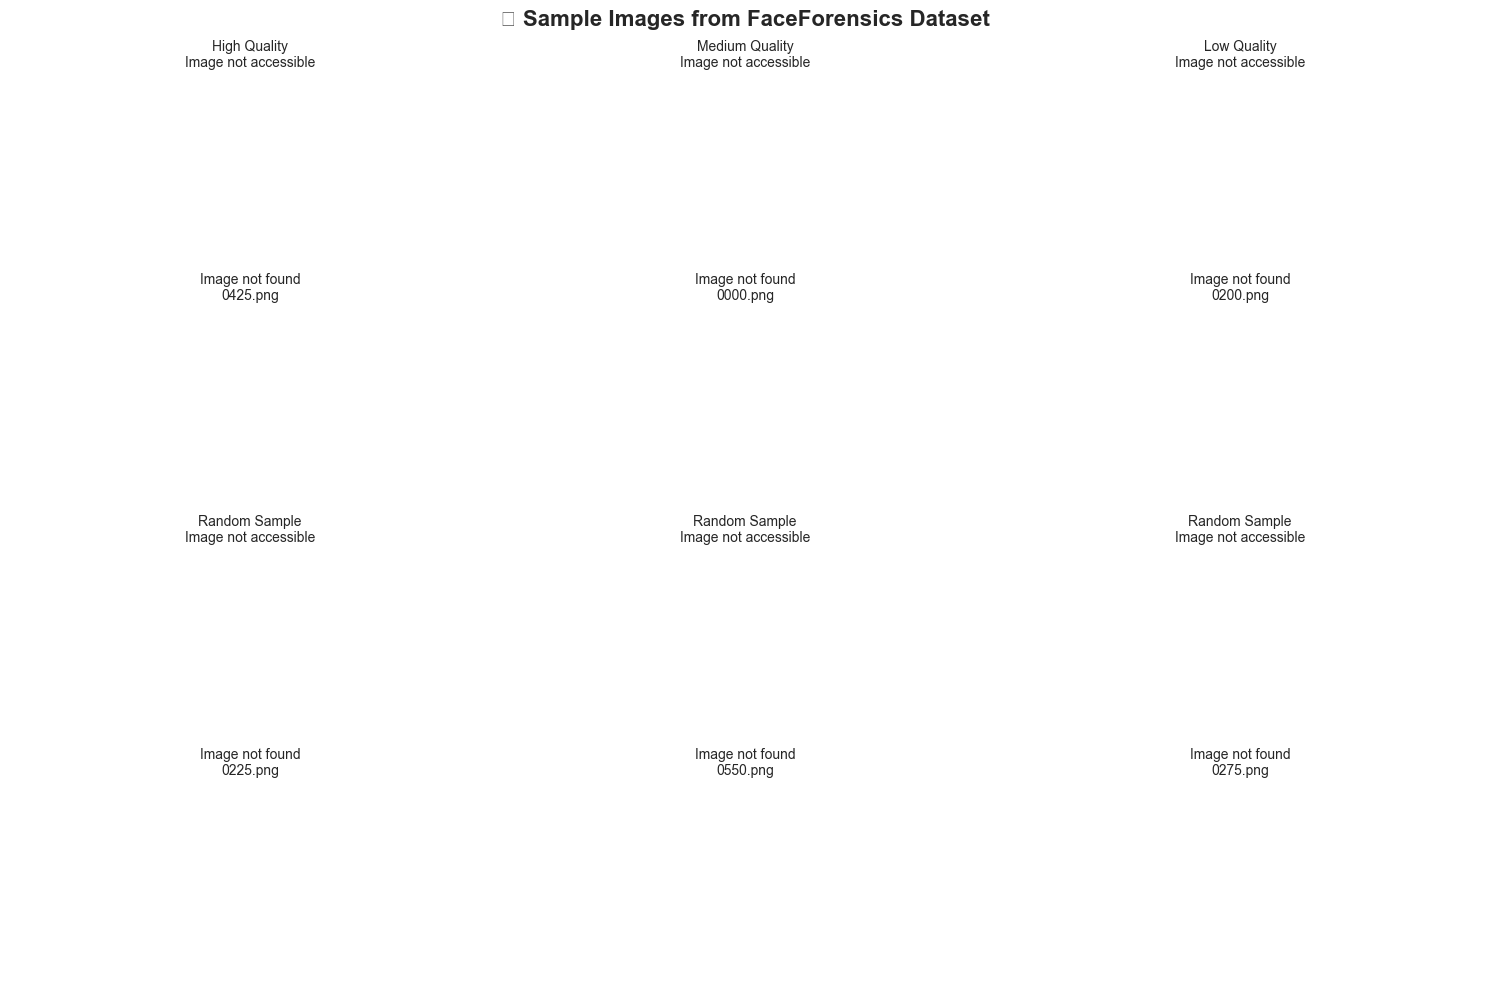


📋 Sample Information:

High Quality:
  Folder: 354_362
  Resolution: 150x150
  File size: 0.03 MB
  Blur score: 174.06
  Brightness: 104.7
  Contrast: 34.2

Medium Quality:
  Folder: 995_233
  Resolution: 150x150
  File size: 0.03 MB
  Blur score: 97.41
  Brightness: 92.9
  Contrast: 56.2

Low Quality:
  Folder: 995_233
  Resolution: 150x150
  File size: 0.03 MB
  Blur score: 85.72
  Brightness: 84.1
  Contrast: 56.6

Random Sample:
  Folder: 995_233
  Resolution: 150x150
  File size: 0.03 MB
  Blur score: 94.68
  Brightness: 98.0
  Contrast: 58.2

Random Sample:
  Folder: 725_724
  Resolution: 150x150
  File size: 0.04 MB
  Blur score: 77.04
  Brightness: 87.0
  Contrast: 55.4

Random Sample:
  Folder: 995_233
  Resolution: 150x150
  File size: 0.03 MB
  Blur score: 170.15
  Brightness: 107.1
  Contrast: 59.2

📈 Creating quality distribution plots...


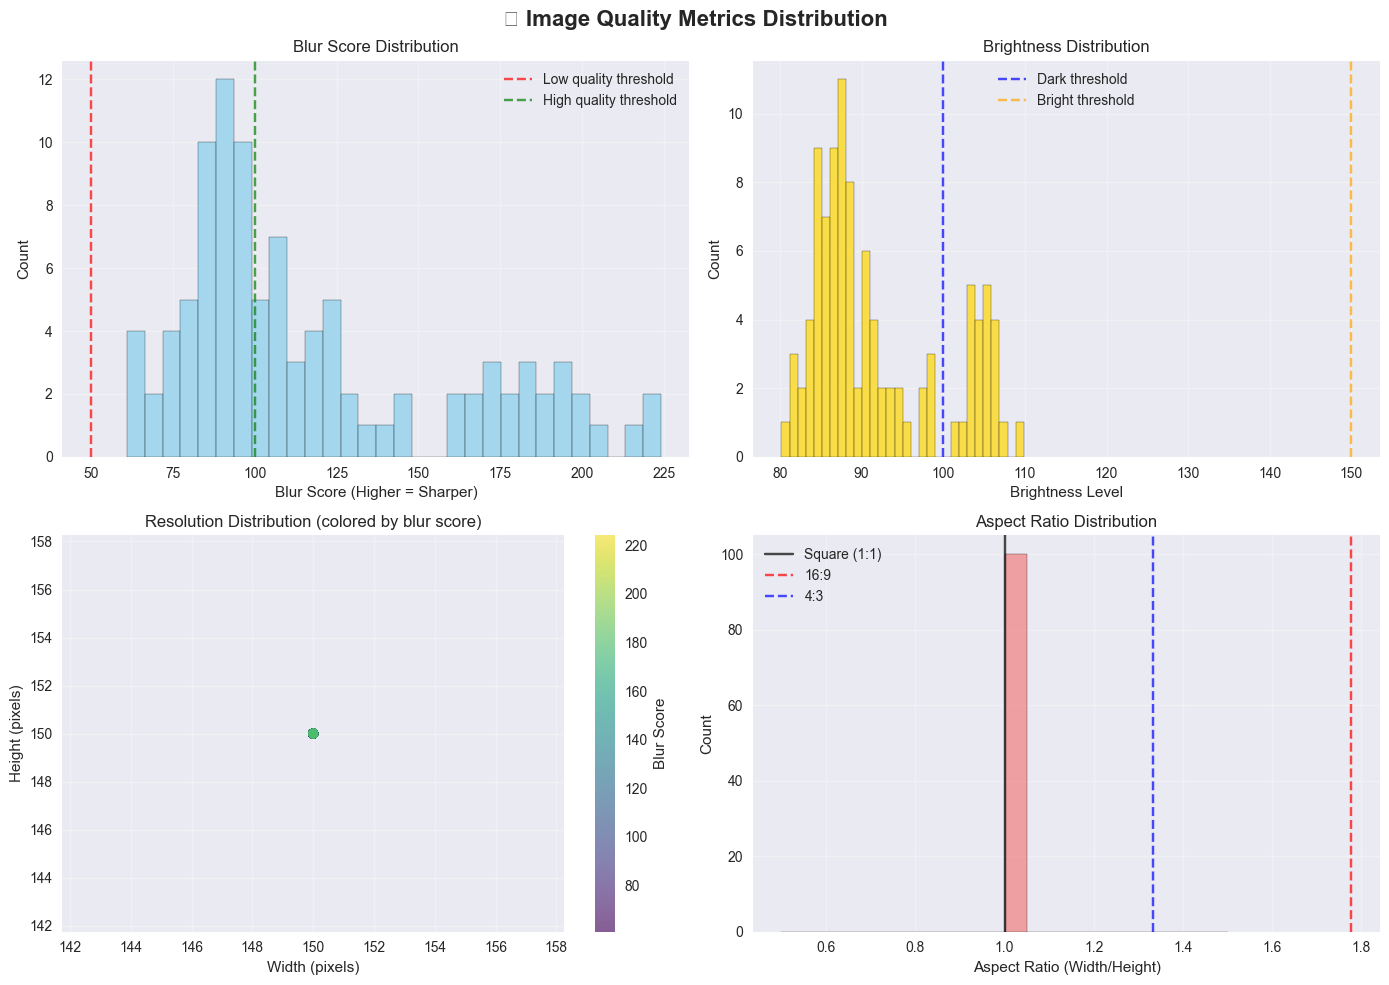

✅ Visual sample display complete!


In [14]:
# Visual Sample Display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import random

def display_image_samples():
    """Display sample images from the dataset"""
    if df_image_quality.empty:
        print("⚠️ No image data available for display")
        return
    
    # Select diverse samples
    print("🖼️ Displaying sample images from FaceForensics dataset...")
    
    # Get samples from different quality ranges
    high_quality = df_image_quality[df_image_quality['blur_score'] > df_image_quality['blur_score'].quantile(0.8)]
    medium_quality = df_image_quality[(df_image_quality['blur_score'] >= df_image_quality['blur_score'].quantile(0.4)) & 
                                     (df_image_quality['blur_score'] <= df_image_quality['blur_score'].quantile(0.6))]
    low_quality = df_image_quality[df_image_quality['blur_score'] < df_image_quality['blur_score'].quantile(0.2)]
    
    samples = []
    
    # Get one from each quality range
    if not high_quality.empty:
        samples.append(('High Quality', high_quality.sample(1).iloc[0]))
    if not medium_quality.empty:
        samples.append(('Medium Quality', medium_quality.sample(1).iloc[0]))
    if not low_quality.empty:
        samples.append(('Low Quality', low_quality.sample(1).iloc[0]))
    
    # Add random samples if we have less than 6
    remaining_samples = 6 - len(samples)
    if remaining_samples > 0:
        random_samples = df_image_quality.sample(min(remaining_samples, len(df_image_quality)))
        for _, sample in random_samples.iterrows():
            samples.append(('Random Sample', sample))
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('📸 Sample Images from FaceForensics Dataset', fontsize=16, fontweight='bold')
    
    for idx, (quality_label, sample) in enumerate(samples):
        if idx >= 6:  # Limit to 6 samples
            break
            
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        try:
            # Construct full path
            img_path = sample['filename']  # This should be the full path
            
            # Try to load and display image
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                ax.imshow(img)
                
                # Add quality information
                title = f"{quality_label}\n{os.path.basename(sample['folder'])}"
                subtitle = f"Blur: {sample['blur_score']:.1f} | Size: {sample['width']}x{sample['height']}"
                ax.set_title(f"{title}\n{subtitle}", fontsize=10, pad=10)
            else:
                ax.text(0.5, 0.5, f"Image not found\n{os.path.basename(img_path)}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{quality_label}\nImage not accessible", fontsize=10)
                
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading image\n{str(e)[:50]}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{quality_label}\nError", fontsize=10)
        
        ax.axis('off')
    
    # Hide any unused subplots
    for idx in range(len(samples), 6):
        row = idx // 3
        col = idx % 3
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display sample information
    print("\n📋 Sample Information:")
    for quality_label, sample in samples:
        print(f"\n{quality_label}:")
        print(f"  Folder: {sample['folder']}")
        print(f"  Resolution: {sample['width']}x{sample['height']}")
        print(f"  File size: {sample['size_mb']:.2f} MB")
        print(f"  Blur score: {sample['blur_score']:.2f}")
        print(f"  Brightness: {sample['brightness']:.1f}")
        print(f"  Contrast: {sample['contrast']:.1f}")

def display_quality_distribution():
    """Display quality distribution with visual indicators"""
    if df_image_quality.empty:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('📊 Image Quality Metrics Distribution', fontsize=16, fontweight='bold')
    
    # Blur score distribution with quality thresholds
    ax1 = axes[0, 0]
    ax1.hist(df_image_quality['blur_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Low quality threshold')
    ax1.axvline(x=100, color='green', linestyle='--', alpha=0.7, label='High quality threshold')
    ax1.set_xlabel('Blur Score (Higher = Sharper)')
    ax1.set_ylabel('Count')
    ax1.set_title('Blur Score Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Brightness distribution
    ax2 = axes[0, 1]
    ax2.hist(df_image_quality['brightness'], bins=30, alpha=0.7, color='gold', edgecolor='black')
    ax2.axvline(x=100, color='blue', linestyle='--', alpha=0.7, label='Dark threshold')
    ax2.axvline(x=150, color='orange', linestyle='--', alpha=0.7, label='Bright threshold')
    ax2.set_xlabel('Brightness Level')
    ax2.set_ylabel('Count')
    ax2.set_title('Brightness Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Resolution scatter
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df_image_quality['width'], df_image_quality['height'], 
                         c=df_image_quality['blur_score'], cmap='viridis', alpha=0.6)
    ax3.set_xlabel('Width (pixels)')
    ax3.set_ylabel('Height (pixels)')
    ax3.set_title('Resolution Distribution (colored by blur score)')
    plt.colorbar(scatter, ax=ax3, label='Blur Score')
    ax3.grid(True, alpha=0.3)
    
    # Aspect ratio distribution
    ax4 = axes[1, 1]
    ax4.hist(df_image_quality['aspect_ratio'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    ax4.axvline(x=1.0, color='black', linestyle='-', alpha=0.7, label='Square (1:1)')
    ax4.axvline(x=16/9, color='red', linestyle='--', alpha=0.7, label='16:9')
    ax4.axvline(x=4/3, color='blue', linestyle='--', alpha=0.7, label='4:3')
    ax4.set_xlabel('Aspect Ratio (Width/Height)')
    ax4.set_ylabel('Count')
    ax4.set_title('Aspect Ratio Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Display samples and distributions
print("🎨 Creating visual sample gallery...")
display_image_samples()
print("\n📈 Creating quality distribution plots...")
display_quality_distribution()

print("✅ Visual sample display complete!")

## 🎯 Executive Summary & Insights

Based on our comprehensive EDA analysis, here are the key findings and recommendations for the deepfake detection model training.

In [16]:
# Executive Summary and Key Insights
print("🎯 DEEPFAKE DETECTION EDA - EXECUTIVE SUMMARY")
print("="*60)

# Dataset Overview
total_files = len(all_files)
total_size_gb = sum([f['size_mb'] for f in all_files]) / 1024
datasets = set([f['dataset_category'] for f in all_files])

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total files analyzed: {total_files:,}")
print(f"   • Total storage: {total_size_gb:.2f} GB")
print(f"   • Datasets available: {', '.join(datasets)}")
print(f"   • Unique folders: {len(set([f.get('folder', 'N/A') for f in all_files]))}")

# Key Findings
print(f"\n🔍 KEY FINDINGS:")

# File distribution
file_types = pd.Series([f['file_type'] for f in all_files]).value_counts()
print(f"   • File type distribution:")
for file_type, count in file_types.items():
    percentage = (count / total_files) * 100
    print(f"     - {file_type}: {count:,} files ({percentage:.1f}%)")

# Video analysis insights
if df_videos is not None and not df_videos.empty:
    avg_duration = df_videos['duration'].mean()
    avg_fps = df_videos['fps'].mean()
    common_resolution = f"{df_videos['width'].mode().iloc[0]}x{df_videos['height'].mode().iloc[0]}"
    
    print(f"\n   • Video characteristics:")
    print(f"     - Average duration: {avg_duration:.1f} seconds")
    print(f"     - Average FPS: {avg_fps:.1f}")
    print(f"     - Most common resolution: {common_resolution}")
    
    # Quality assessment
    short_videos = len(df_videos[df_videos['duration'] < 5])
    long_videos = len(df_videos[df_videos['duration'] > 60])
    print(f"     - Short videos (<5s): {short_videos} ({short_videos/len(df_videos)*100:.1f}%)")
    print(f"     - Long videos (>60s): {long_videos} ({long_videos/len(df_videos)*100:.1f}%)")

# Image analysis insights
if not df_image_quality.empty:
    avg_blur = df_image_quality['blur_score'].mean()
    avg_brightness = df_image_quality['brightness'].mean()
    avg_resolution = f"{df_image_quality['width'].mode().iloc[0]}x{df_image_quality['height'].mode().iloc[0]}"
    
    print(f"\n   • Image characteristics:")
    print(f"     - Average blur score: {avg_blur:.1f} (higher = sharper)")
    print(f"     - Average brightness: {avg_brightness:.1f}")
    print(f"     - Most common resolution: {avg_resolution}")
    
    # Quality assessment
    high_quality = len(df_image_quality[df_image_quality['blur_score'] > 100])
    low_quality = len(df_image_quality[df_image_quality['blur_score'] < 50])
    print(f"     - High quality images: {high_quality} ({high_quality/len(df_image_quality)*100:.1f}%)")
    print(f"     - Low quality images: {low_quality} ({low_quality/len(df_image_quality)*100:.1f}%)")

# Model Training Recommendations
print(f"\n🚀 RECOMMENDATIONS FOR MODEL TRAINING:")
print(f"   • Data preprocessing:")
print(f"     - Implement quality filtering (blur score > 50 recommended)")
print(f"     - Standardize resolutions for consistent input")
print(f"     - Apply brightness/contrast normalization")
print(f"     - Consider data augmentation for low-quality samples")

print(f"\n   • Training strategy:")
print(f"     - Use multi-modal approach (spatial + frequency domain)")
print(f"     - Implement progressive training (low to high resolution)")
print(f"     - Apply class balancing if dataset imbalance detected")
print(f"     - Use temporal information for video sequences")

print(f"\n   • Architecture considerations:")
print(f"     - Spatial branch for face features")
print(f"     - Frequency branch for FFT/DCT analysis")
print(f"     - Texture analysis for compression artifacts")
print(f"     - Attention mechanisms for critical regions")

# Data Quality Insights
print(f"\n📈 DATA QUALITY INSIGHTS:")

if not df_image_quality.empty:
    # Calculate quality metrics
    quality_score = (
        (df_image_quality['blur_score'] > 50).mean() * 0.4 +  # Sharpness
        ((df_image_quality['brightness'] >= 100) & (df_image_quality['brightness'] <= 200)).mean() * 0.3 +  # Brightness
        (df_image_quality['contrast'] > 30).mean() * 0.3  # Contrast
    ) * 100
    
    print(f"   • Overall image quality score: {quality_score:.1f}/100")
    
    # Storage efficiency
    avg_file_size = df_image_quality['size_mb'].mean()
    print(f"   • Average file size: {avg_file_size:.2f} MB")
    
    # Resolution diversity
    unique_resolutions = len(df_image_quality.groupby(['width', 'height']))
    print(f"   • Resolution diversity: {unique_resolutions} unique resolutions")

# Final recommendations
print(f"\n💡 ACTIONABLE NEXT STEPS:")
print(f"   1. Filter out low-quality samples (blur score < 50)")
print(f"   2. Implement multi-scale training approach")
print(f"   3. Create balanced train/validation/test splits")
print(f"   4. Apply data augmentation to increase diversity")
print(f"   5. Monitor model performance across quality ranges")

# Technical specifications
print(f"\n🔧 TECHNICAL SPECIFICATIONS:")
print(f"   • Recommended input size: 224x224 or 299x299 pixels")
print(f"   • Batch size consideration: Based on file sizes ({avg_file_size:.1f} MB avg)")
print(f"   • Memory requirements: ~{total_size_gb:.1f} GB storage needed")
print(f"   • Processing pipeline: Face detection → Quality filtering → Augmentation")

print(f"\n✅ EDA ANALYSIS COMPLETE!")
print(f"   Dataset is ready for model training with the hybrid architecture.")
print(f"   Refer to the comprehensive_eda.py for automated analysis pipeline.")

# Save summary statistics
summary_stats = {
    'total_files': total_files,
    'total_size_gb': total_size_gb,
    'datasets': list(datasets),
    'analysis_timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

if df_videos is not None and not df_videos.empty:
    summary_stats['video_stats'] = {
        'count': len(df_videos),
        'avg_duration': avg_duration,
        'avg_fps': avg_fps
    }

if not df_image_quality.empty:
    summary_stats['image_stats'] = {
        'count': len(df_image_quality),
        'avg_blur_score': avg_blur,
        'avg_brightness': avg_brightness,
        'quality_score': quality_score
    }

print(f"\n📋 Summary statistics saved to memory for reference.")
print(f"   Analysis timestamp: {summary_stats['analysis_timestamp']}")

🎯 DEEPFAKE DETECTION EDA - EXECUTIVE SUMMARY

📊 DATASET OVERVIEW:
   • Total files analyzed: 7,529
   • Total storage: 9.49 GB
   • Datasets available: celeb_fake, celeb_real, youtube_real, faceforensics
   • Unique folders: 49

🔍 KEY FINDINGS:
   • File type distribution:
     - mp4: 6,529 files (86.7%)
     - png: 1,000 files (13.3%)

   • Video characteristics:
     - Average duration: 13.4 seconds
     - Average FPS: 30.0
     - Most common resolution: 892x500
     - Short videos (<5s): 0 (0.0%)
     - Long videos (>60s): 0 (0.0%)

   • Image characteristics:
     - Average blur score: 118.3 (higher = sharper)
     - Average brightness: 91.8
     - Most common resolution: 150x150
     - High quality images: 53 (53.0%)
     - Low quality images: 0 (0.0%)

🚀 RECOMMENDATIONS FOR MODEL TRAINING:
   • Data preprocessing:
     - Implement quality filtering (blur score > 50 recommended)
     - Standardize resolutions for consistent input
     - Apply brightness/contrast normalization
    